## Welcome back to Python Notebooks!

Didja miss me??

### And welcome to Week 4, Day 2 - introducing LangGraph!

In [1]:
# 導入型別註解工具，方便後續型別標註與說明
from typing import Annotated
# 從 langgraph 套件導入 StateGraph 類別，以及流程起點與終點常數
from langgraph.graph import StateGraph, START, END
# 導入 add_messages，作為狀態更新的 reducer 函式
from langgraph.graph.message import add_messages
# 載入 .env 檔案中的環境變數，通常用於 API 金鑰等敏感資訊
from dotenv import load_dotenv
# 導入 IPython.display 的 Image 與 display，用於在 notebook 中顯示圖片
from IPython.display import Image, display
# 導入 gradio 套件，建立互動式網頁介面
import gradio as gr
# 再次導入 StateGraph（重複，實際可省略）
from langgraph.graph import StateGraph
# 再次導入 add_messages（重複，實際可省略）
from langgraph.graph.message import add_messages
# 從 langchain_openai 套件導入 ChatOpenAI，建立 OpenAI 聊天模型物件
from langchain_openai import ChatOpenAI
# 導入 pydantic 的 BaseModel，方便建立結構化資料模型
from pydantic import BaseModel
# 導入 random 模組，用於隨機選取資料
import random


In [2]:
# Some useful constants

nouns = ["Cabbages", "Unicorns", "Toasters", "Penguins", "Bananas", "Zombies", "Rainbows", "Eels", "Pickles", "Muffins"]
adjectives = ["outrageous", "smelly", "pedantic", "existential", "moody", "sparkly", "untrustworthy", "sarcastic", "squishy", "haunted"]

In [3]:
# Our favorite first step! Crew was doing this for us, by the way.
load_dotenv(override=True)


True

In [4]:
# 使用 Annotated 來為型別註解添加額外說明資訊
# 這裡 "something to be shouted" 是給人或工具看的補充說明
def shout(text: Annotated[str, "something to be shouted"]) -> str:
    print(text.upper())
    return text.upper()

shout("hello")

HELLO


'HELLO'

### 關於「Annotated」的說明

你可能已經知道，型別提示（type hinting）是 Python 的一項功能，可以讓你指定某個變數的型別：

`my_favorite_things: List`

但你可能不知道：

你也可以使用「Annotated」來為型別添加額外資訊，讓其他人或工具能更好地理解用途：

`my_favorite_things: Annotated[List, "these are a few of mine"]`

LangGraph 需要我們在定義 State 物件時使用這個功能。

它希望我們告訴它，當 State 需要更新新值時，應該呼叫哪個函式。

這個函式稱為 **reducer**（狀態合併器）。

LangGraph 提供了一個預設的 reducer，叫做 `add_messages`，可以處理最常見的情境。

這也解釋了為什麼 State 物件會長這樣。





### Step 1: Define the State object

You can use any python object; but it's most common to use a TypedDict or a Pydantic BaseModel.

In [5]:

class State(BaseModel):
        
    messages: Annotated[list, add_messages]


### Step 2: Start the Graph Builder with this State class

In [6]:
# 使用 State 類別初始化 StateGraph，建立狀態流程圖物件，後續可用於定義節點與流程
# StateGraph 會根據 State 的結構管理狀態流轉
graph_builder = StateGraph(State)

### 步驟 3：建立節點

節點可以是任何 Python 函式。

前面設定的 reducer 會自動被呼叫，用來將這次的回應與先前的回應合併。


In [7]:
def our_first_node(old_state: State) -> State:

    reply = f"{random.choice(nouns)} are {random.choice(adjectives)}"
    messages = [{"role": "assistant", "content": reply}]

    new_state = State(messages=messages)

    return new_state

graph_builder.add_node("first_node", our_first_node)

### Step 4: Create Edges

In [8]:
graph_builder.add_edge(START, "first_node")
graph_builder.add_edge("first_node", END)

### Step 5: Compile the Graph

In [9]:
# 編譯已定義的狀態流程圖，產生可執行的 Graph 物件
# 這個物件可用於後續的節點執行與流程管理
graph = graph_builder.compile()

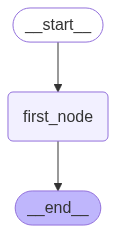

In [10]:
# 以 mermaid 圖表格式繪製狀態流程圖，並在 notebook 中顯示流程圖圖片
# 有助於視覺化流程設計與節點關係
display(Image(graph.get_graph().draw_mermaid_png()))

### That's it! Showtime!

In [ ]:
def chat(user_input: str, history):
    message = {"role": "user", "content": user_input}
    messages = [message]
    state = State(messages=messages)
    result = graph.invoke(state)
    print(result)
    return result["messages"][-1].content


gr.ChatInterface(chat, type="messages").launch()

### But why did I show you that?

To make the point that LangGraph is all about python functions - it doesn't need to involve LLMs!!

Now we'll do the 5 steps again, but in 1 shot:

In [ ]:
# Step 1: Define the State object
class State(BaseModel):
    messages: Annotated[list, add_messages]


In [ ]:
# Step 2: Start the Graph Builder with this State class
# 使用 State 類別初始化 StateGraph，建立狀態流程圖物件，後續可用於定義節點與流程
# StateGraph 會根據 State 的結構管理狀態流轉
graph_builder = StateGraph(State)


In [ ]:
# Step 3: Create a Node

llm = ChatOpenAI(model="gpt-4o-mini")

def chatbot_node(old_state: State) -> State:
    response = llm.invoke(old_state.messages)
    new_state = State(messages=[response])
    return new_state

graph_builder.add_node("chatbot", chatbot_node)

In [ ]:
# Step 4: Create Edges
graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("chatbot", END)

In [ ]:
# Step 5: Compile the Graph
graph = graph_builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

### That's it! And, let's do this:

In [ ]:
def chat(user_input: str, history):
    initial_state = State(messages=[{"role": "user", "content": user_input}])
    result = graph.invoke(initial_state)
    print(result)
    return result['messages'][-1].content


gr.ChatInterface(chat, type="messages").launch()